In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy import stats
import statsmodels.formula.api as smf
import networkx as nx
import plotly.offline as offline
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [61]:
## read the tsv files in MovieSummaries
load_movies = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep = '\t', header = None)
load_character = pd.read_csv('MovieSummaries/character.metadata.tsv', sep = '\t', header = None)

In [62]:
movies = load_movies.copy()
character = load_character.copy()

In [63]:
# Make the name of the colum of movie: wikip_ID, freebase_ID, name, release date, box office, runtime, languages, countries, genres	
movies.columns = ['Wiki_ID', 'Freebase_ID', 'name', 'release_date', 'box_office', 'runtime', 'languages', 'countries', 'genres']
# Make the name of the columns of character wiki_ID, freebase_ID, character_name, actor_DOB, actor_gender, actor_height, actor_ethnicity, actor_name, actor_age, freebase_character_map
character.columns = ['Wiki_ID', 'Freebase_ID','release_date', 'character_name', 'actor_DOB', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', '10', '11', '12']
character = character.drop(['10', '11', '12'], axis = 1)

In [64]:
# Load the CSV file
csv_file_path = 'dictionnaries/movies_genres.csv'
new_genre_df = pd.read_csv(csv_file_path)

# Convert the 'genres' from string to list
new_genre_df['genres'] = new_genre_df['genres'].apply(ast.literal_eval)

movies_clean_gross = movies.copy()

# Merge with the original DataFrame
movies_clean_gross = movies_clean_gross.drop('genres', axis=1, errors='ignore').merge(new_genre_df, on='Wiki_ID')

# Display the merged DataFrame
movies_clean_gross.head()

,Wiki_ID,Freebase_ID,name,release_date,box_office,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Adventure, Action, Science Fiction,..."
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","[Drama, History]"
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Drama, Comedy, Science Fiction, Family Film, ..."
3,21926710,/m/05p45cv,White on Rice,2009,NaN,82.0,{},"{""/m/09c7w0"": ""United States of America""}","[Comedy, Romance Film, Indie]"
4,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Drama, Crime]"


In [65]:
## read grossed merged clean csv
gross = pd.read_csv('gross_merged_clean.csv')
gross_clean = gross.copy()

## Question 1

For The first question we will need the gross of the movies in the different region of the world, as well as their release year and their genre.


In [66]:
# Sum up the gross for each movie in the `gross` dataframe
gross_sum = gross_clean.groupby('Wiki_ID')['gross'].sum().reset_index()

# Merge this sum with the `movies` dataframe
movies_with_gross = movies_clean_gross.merge(gross_sum, on='Wiki_ID', how='left')

# Filter out rows where 'box_office' is not missing
non_missing_box_office = movies_with_gross.dropna(subset=['box_office'])


missing_percentage_before = movies_with_gross['box_office'].isna().sum() / len(movies_with_gross) * 100
print(f"Percentage of missing 'box_office' values before imputation: {missing_percentage_before:.2f}%")

# Check coherence for non-missing 'box_office' values
coherence_check = ((non_missing_box_office['box_office'] - non_missing_box_office['gross']).abs() / non_missing_box_office['box_office']).mean()
print(f"Average coherence deviation: {coherence_check:.2f}")


Percentage of missing 'box_office' values before imputation: 47.12%
Average coherence deviation: 0.34


There are a lot of box_office missing values, and for the ones we have, the summed gross differ from it by 34%, so replacing the Nans by the summed gross will not be accurate.

Instead, we should use the summed gross as the global box office for all the movies, and we can drop the box_office feature.

In [67]:
movies_with_gross = movies_with_gross.drop(columns=['box_office'])

In [68]:
# The release date of the movie is in the format of YYYY-MM-DD, we only need the year 
# so we split the date and only keep the year
movies_clean_release = movies_with_gross.copy()
movies_clean_release['release_date'] = movies_clean_release['release_date'].str[:4]
movies_clean_release['release_date'] = pd.to_numeric(movies_clean_release['release_date'], errors='coerce')
# Here the errors ignore is to keep the nan in the release date column
movies_clean_release['release_date'] = movies_clean_release['release_date'].astype(np.int64, errors='ignore')

In [69]:
movies_clean_genre = movies_clean_release.copy()
# This line is to make the empty list to be nan so the nan are uniform
movies_clean_genre['genres'] = movies_clean_genre['genres'].apply(lambda x: x if len(x) != 0 else np.nan)


In [70]:
gross_genre_release = gross_clean.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_genre_release = gross_genre_release.merge(movies_clean_genre[['Wiki_ID', 'release_date', 'genres']], on = 'Wiki_ID', how = 'left')


In [71]:
# count the numers of nan in genre
missing_genre_value = gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].isna().sum()/gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].shape[0]*100
print('The percentage of missing values in the genre column is {:.2f}%'.format(missing_genre_value))

The percentage of missing values in the genre column is 1.90%


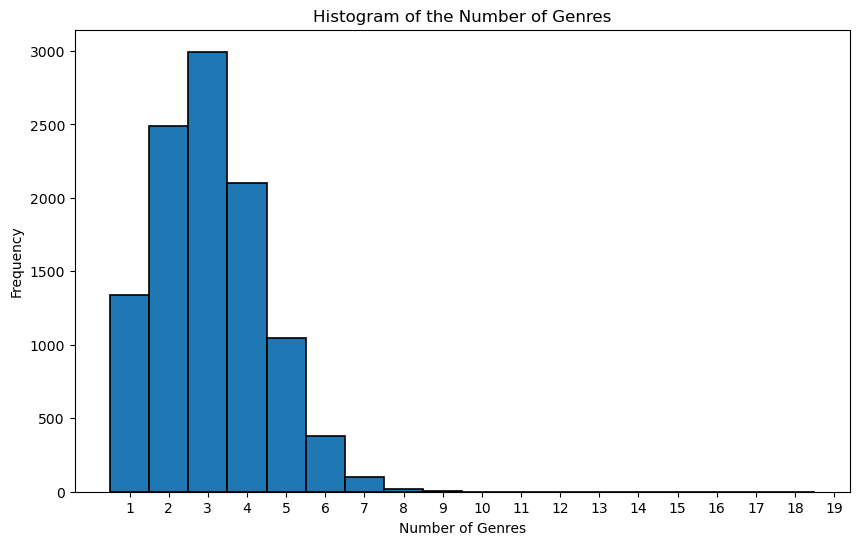

In [72]:
number_of_genres = gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].dropna().apply(lambda x: len(x))
# histogram of the number of genres
plt.figure(figsize=(10, 6))
plt.hist(number_of_genres,bins = np.arange(1, 20, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Genres')
plt.xticks(np.arange(1, 20, 1))
plt.ylabel('Frequency')
plt.title('Histogram of the Number of Genres')
plt.show()

In [73]:
# Calculate the number of genres for each movie
number_of_genres = gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].dropna().apply(lambda x: len(x))

# Create an interactive histogram
fig = go.Figure(data=[go.Histogram(
    x=number_of_genres,
    xbins=dict(start=0.5, end=19.5, size=1),  # Bin size and range
    marker=dict(line=dict(width=1.2, color='black')),  # Border line for each bin
    autobinx=False,  # Disable automatic bin sizing
    hoverinfo='y'  # Show count in hover text
)])

# Update the layout
fig.update_layout(
    title='Histogram of the Number of Genres',
    xaxis=dict(
        title='Number of Genres',
        dtick=1  
    ),
    yaxis_title='Frequency',
    bargap=0  
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/nb_genres.html', auto_open=False)

# Show the figure
fig.show()

We have a very low percentage of genre missing we can therefore have a good analysis about this metric. We don't have any missing values for the release date because it was used as a key when merging the IMdB dataset with the CMU datset

## Question 3 

In [74]:
movies_clean_country = movies_clean_genre.copy()
movies_clean_country['countries'] = movies_clean_country['countries'].apply(lambda x: list(ast.literal_eval(x).values()))
# This line is to make the empty list to be nan so the nan are uniform
movies_clean_country['countries'] = movies_clean_country['countries'].apply(lambda x: x if len(x) != 0 else np.nan)

In [75]:
gross_country = gross_genre_release.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_country = gross_country.merge(movies_clean_country[['Wiki_ID', 'countries']], on = 'Wiki_ID', how = 'left')

In [76]:
# count the numers of nan in countries
missing_country_value = gross_country.drop_duplicates(subset='Wiki_ID')['countries'].isna().sum()/gross_country.drop_duplicates(subset='Wiki_ID')['countries'].shape[0]*100
print('The percentage of missing values in the countries column is {:.2f}%'.format(missing_country_value))

The percentage of missing values in the countries column is 1.70%


In [77]:
coprood_count = gross_country.dropna(subset='countries')
coprood_count = coprood_count.drop_duplicates(subset='Wiki_ID')[coprood_count['countries'].apply(lambda x: len(x)) > 1].shape[0]/gross_country.drop_duplicates(subset='Wiki_ID')['countries'].shape[0]*100

print('The number of movies that are co-produced by more than one country is {:.2f}%'.format(coprood_count))

The number of movies that are co-produced by more than one country is 24.98%


/tmp/ipykernel_29899/30425266.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



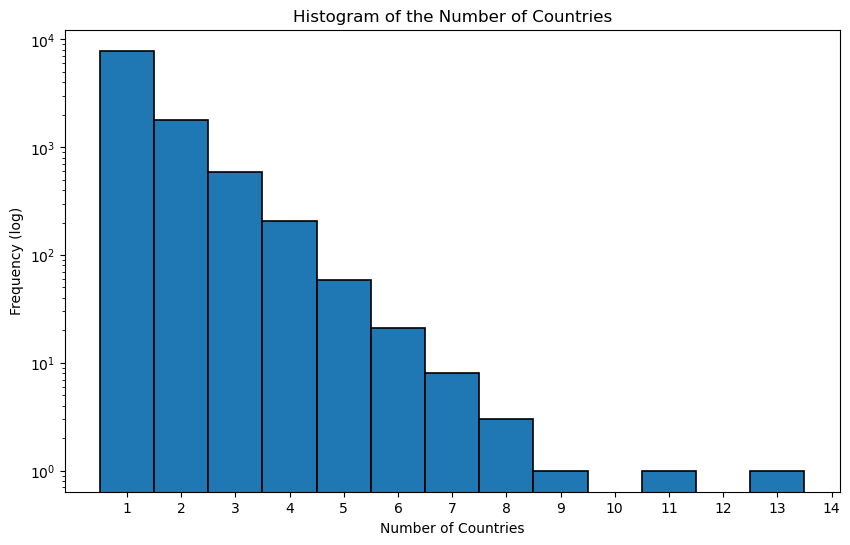

In [78]:
number_of_countries = gross_country.drop_duplicates(subset='Wiki_ID')['countries'].dropna().apply(lambda x: len(x))
# histogram of the number of production countries
plt.figure(figsize=(10, 6))
plt.hist(number_of_countries,bins = np.arange(1, 15, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Countries')
plt.xticks(np.arange(1, 15, 1))
plt.yscale('log')
plt.ylabel('Frequency (log)')
plt.title('Histogram of the Number of Countries')
plt.show()

In [79]:
# Calculate the number of countries for each movie
number_of_countries = gross_country.drop_duplicates(subset='Wiki_ID')['countries'].dropna().apply(lambda x: len(x))

# Create an interactive histogram
fig = go.Figure(data=[go.Histogram(
    x=number_of_countries,
    xbins=dict(start=0.5, end=14.5, size=1),  # Bin size and range
    marker=dict(line=dict(width=1.2, color='black')),  # Border line for each bin
    autobinx=False  # Disable automatic bin sizing
)])

# Update the layout
fig.update_layout(
    title='Histogram of the Number of Countries',
    xaxis=dict(
        title='Number of Countries',
        dtick=1  # Ticks at every integer
    ),
    yaxis=dict(
        title='Frequency (log)',
        type='log'  # Logarithmic scale for y-axis
    ),
    bargap=0  # No gap between bars
)

# Save the plot as an HTML file
# offline.plot(fig, filename='docs/plots/nb_countries.html', auto_open=False)

# Show the figure
fig.show()

We have a very low percentage of countries missing we can therefore have a good analysis about this metric. And the level of co-production is relatively high so it will still make sense to do our analysis.

## Question 4

For the gender representation in the movie. We decided to only use the values that were given for each of the movies, making the assumption that if the gender of an actor is not given the character was probably a small part. 

In [80]:
# go in the character dataset and find the percentage of gender F in each movie
character_gender = character.copy()

#count the number of "F" for each wiki_ID in character_gender
# groupby wiki_ID and count the number of "F" in each group
character_groupby = character_gender.groupby('Wiki_ID')
character_groupby_tot = character_groupby["actor_gender"].count()
character_groupby_F = character_groupby.apply(lambda x: (x['actor_gender'] == 'F').sum())
ratio_female_to_total = character_groupby_F / character_groupby_tot



In [81]:
data = {
    'Wiki_ID': ratio_female_to_total.index,
    'Ratio_Female_to_Total': ratio_female_to_total.values,
    'num_female': character_groupby_F.values,
    'num_male': character_groupby_tot.values - character_groupby_F.values
}

# Create DataFrame
df_ratio = pd.DataFrame(data)

# Reset the index to make it 1-dimensional
df_ratio.reset_index(drop=True, inplace=True)

In [82]:
movies_clean_gender = movies_clean_country.copy()
movies_clean_gender = movies_clean_gender.merge(df_ratio, on = 'Wiki_ID', how = 'left')
movies_clean_gender.head()

,Wiki_ID,Freebase_ID,name,release_date,runtime,languages,countries,genres,gross,Ratio_Female_to_Total,num_female,num_male
0,975900,/m/03vyhn,Ghosts of Mars,2001,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Adventure, Action, Science Fiction,...",11996794.0,0.352941,6.0,11.0
1,171005,/m/016ywb,Henry V,1989,137.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Drama, History]",10161099.0,0.150000,3.0,17.0
2,77856,/m/0kcn7,Mary Poppins,1964,139.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Drama, Comedy, Science Fiction, Family Film, ...",103078757.0,0.461538,6.0,7.0
3,21926710,/m/05p45cv,White on Rice,2009,82.0,{},[United States of America],"[Comedy, Romance Film, Indie]",69171.0,0.555556,5.0,4.0
4,156558,/m/014k4y,Baby Boy,2001,123.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Drama, Crime]",28907684.0,0.521739,12.0,11.0


In [83]:
gross_gender = gross_country.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_gender = gross_gender.merge(movies_clean_gender[['Wiki_ID', 'Ratio_Female_to_Total', 'num_female', 'num_male']], on = 'Wiki_ID', how = 'left')
gross_gender

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,genres,countries,Ratio_Female_to_Total,num_female,num_male
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[United States of America],0.352941,6.0,11.0
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[United States of America],0.352941,6.0,11.0
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[United States of America],0.352941,6.0,11.0
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[United States of America],0.352941,6.0,11.0
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[United States of America],0.352941,6.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
90661,tt0120202,1918494,/m/0660qx,Denmark,state and main,13732.0,2000.0,"[Drama, Comedy]","[France, United States of America]",0.181818,4.0,18.0
90662,tt0120202,1918494,/m/0660qx,Australia,state and main,385631.0,2000.0,"[Drama, Comedy]","[France, United States of America]",0.181818,4.0,18.0
90663,tt0107057,664006,/m/030xw6,Domestic,guilty as sin,22866222.0,1993.0,"[Drama, Thriller, Crime]",[United States of America],0.375000,3.0,5.0
90664,tt1606259,34980460,/m/0g4pl34,Domestic,knuckle,2647.0,2011.0,"[Drama, Documentary]","[Ireland, United Kingdom]",NaN,NaN,NaN


In [84]:
# Analyzing Ethnicity Data
print(f"Total entries in character dataframe: {len(character)}")

# Check for missing values in 'actor_ethnicity'
missing_ethnicity = character['actor_ethnicity'].isna().sum()
print(f"Number of missing values in 'actor_ethnicity': {missing_ethnicity}")
print(f"Percentage of missing values in 'actor_ethnicity': {missing_ethnicity / len(character) * 100:.2f}%")

Total entries in character dataframe: 450669
Number of missing values in 'actor_ethnicity': 344611
Percentage of missing values in 'actor_ethnicity': 76.47%


In [85]:
#Filling Nan with 'Unknown' ethnicity
character_ethnicity = character_gender.copy()
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity']

# Analyzing ethnicity distribution
ethnicity_distribution = character['actor_ethnicity'].value_counts(normalize=True) * 100
print(ethnicity_distribution)

actor_ethnicity
/m/0dryh9k    15.417036
/m/0x67        9.578721
/m/041rx       9.542892
/m/02w7gg      5.812857
/m/033tf_      3.636689
                ...    
/m/043_z22     0.000943
/m/03x_fq7     0.000943
/m/01hphz      0.000943
/m/033fjj      0.000943
/m/013y54      0.000943
Name: proportion, Length: 479, dtype: float64


We have the distribution of the ethnicities, but they are encoded as ids. Lets decode them :

In [86]:
# Load the CSV file into a DataFrame
ethnicity_labels_df = pd.read_csv('./dictionnaries/ethnicity_labels.csv')

# Convert the DataFrame to a dictionary
ethnicity_labels = dict(zip(ethnicity_labels_df['Freebase ID'], ethnicity_labels_df['Ethnicity Label']))

# Replace the codes in 'ethnicity_distribution' with their labels
ethnicity_distribution_labeled = ethnicity_distribution.rename(index=ethnicity_labels)

# Print the updated distribution
print(ethnicity_distribution_labeled)

actor_ethnicity
Indian person             15.417036
African Americans          9.578721
Jewish people              9.542892
English people             5.812857
Irish Americans            3.636689
                            ...    
/m/043_z22                 0.000943
Aboriginal Australians     0.000943
Indian diaspora            0.000943
Ho-Chunk                   0.000943
Han Chinese people         0.000943
Name: proportion, Length: 479, dtype: float64


We can see that some ethnicities aren't translated. Lets analyse them.

In [87]:
# Identifying untranslated ethnicity codes
untranslated_codes = set(character_ethnicity['actor_ethnicity']) - set(ethnicity_labels.keys())
untranslated_codes = {code for code in untranslated_codes if isinstance(code, str)}  # Ensure that NaNs are not included

# Counting the number of untranslated ethnicities
untranslated_counts = character_ethnicity['actor_ethnicity'].apply(lambda x: x if x in untranslated_codes else np.nan).value_counts()

character_ethnicity_df = character_ethnicity.copy()

# Find the most common untranslated ethnicity
if not untranslated_counts.empty:
    most_common_untranslated = untranslated_counts.idxmax()
    most_common_untranslated_count = untranslated_counts.max()
    print(f"Most common untranslated ethnicity: {most_common_untranslated} ({most_common_untranslated_count} occurrences)")

    print("Five most common untranslated ethnicities:")
    print(untranslated_counts.head(5))

else:
    print("No untranslated ethnicity codes found.")

Most common untranslated ethnicity: /m/044038p (1885 occurrences)
Five most common untranslated ethnicities:
actor_ethnicity
/m/044038p    1885
/m/02p1pl6     200
/m/04tvpv      197
/m/02p656s     121
/m/0283js_      81
Name: count, dtype: int64


There are 1885 actors with ethnicity '/m/044038p'. Lets see who they are.

In [88]:
# Filter for actors with the specified ethnicity code
actors_with_specific_ethnicity = character_ethnicity[character_ethnicity['actor_ethnicity'] == '/m/044038p']

# Select 10 actors from this group
sample_actors = actors_with_specific_ethnicity.sample(10)

# Print the selected actors
print(sample_actors[['actor_name', 'actor_ethnicity']])

             actor_name actor_ethnicity
151959     Ryan Robbins      /m/044038p
337813    Kirsten Prout      /m/044038p
236510    Paul Campbell      /m/044038p
109203       Tom Butler      /m/044038p
159821     Kevin Durand      /m/044038p
30249      John Kapelos      /m/044038p
15171          Rick Fox      /m/044038p
390071    Ryan Reynolds      /m/044038p
387282   Joanna Gleason      /m/044038p
335694  Bruce Greenwood      /m/044038p


Those 10 actors are all canadians. We will call this ethnicity 'Canadians'.

In [89]:
# Define a function to replace unknown ethnicities
def replace_unknown_ethnicities(ethnicity):
    if ethnicity == '/m/044038p':
        return 'Canadians'
    elif not ethnicity in ethnicity_labels.keys():
        return 'Unknown'
    else:
        return ethnicity

# Apply the function to the actor_ethnicity column
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity'].apply(replace_unknown_ethnicities)

print(character_ethnicity.head())

   Wiki_ID Freebase_ID release_date              character_name   actor_DOB  \
0   975900   /m/03vyhn   2001-08-24                    Akooshay  1958-08-26   
1   975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard  1974-08-15   
2   975900   /m/03vyhn   2001-08-24         Desolation Williams  1969-06-15   
3   975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler  1967-09-12   
4   975900   /m/03vyhn   2001-08-24             Bashira Kincaid  1977-09-25   

  actor_gender  actor_height actor_ethnicity          actor_name  actor_age  
0            F         1.620         Unknown      Wanda De Jesus       42.0  
1            F         1.780       Canadians  Natasha Henstridge       27.0  
2            M         1.727         /m/0x67            Ice Cube       32.0  
3            M         1.750         Unknown       Jason Statham       33.0  
4            F         1.650         Unknown         Clea DuVall       23.0  


In [90]:
# Replace 'Unknown' with np.nan in the actor_ethnicity column
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity'].replace('Unknown', np.nan)

# Optionally, print a few rows to verify the changes
print(character_ethnicity.head())

   Wiki_ID Freebase_ID release_date              character_name   actor_DOB  \
0   975900   /m/03vyhn   2001-08-24                    Akooshay  1958-08-26   
1   975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard  1974-08-15   
2   975900   /m/03vyhn   2001-08-24         Desolation Williams  1969-06-15   
3   975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler  1967-09-12   
4   975900   /m/03vyhn   2001-08-24             Bashira Kincaid  1977-09-25   

  actor_gender  actor_height actor_ethnicity          actor_name  actor_age  
0            F         1.620             NaN      Wanda De Jesus       42.0  
1            F         1.780       Canadians  Natasha Henstridge       27.0  
2            M         1.727         /m/0x67            Ice Cube       32.0  
3            M         1.750             NaN       Jason Statham       33.0  
4            F         1.650             NaN         Clea DuVall       23.0  


In [91]:
def extract_languages(lang_str):
    if pd.isna(lang_str):
        return ['Unknown']
    try:
        # Parse the string as a dictionary
        lang_dict = ast.literal_eval(lang_str)
        # Extract the language names and remove 'Language' from the end
        languages = [lang.split(' Language')[0] for lang in lang_dict.values()]

        return languages
    except ValueError:
        # Handle cases where lang_str cannot be parsed
        return ['Unknown']

movies_clean_languages = movies_clean_country.copy()
movies_clean_languages['languages'] = movies_clean_languages['languages'].apply(extract_languages)

# Counting languages
language_counts = pd.Series([lang for sublist in movies_clean_languages['languages'] for lang in sublist]).value_counts()
print(language_counts)

English                       8659
French                         769
Spanish                        615
Hindi                          486
German                         354
                              ... 
Cebuano language                 1
Aboriginal Malay languages       1
Kannada                          1
Slovenian language               1
Hinglish                         1
Name: count, Length: 150, dtype: int64


In [92]:
gross_language = gross_gender.copy()
#merge gross_gender and movies_clean_language on wiki_ID
gross_language = gross_language.merge(movies_clean_languages[['Wiki_ID', 'languages']], on = 'Wiki_ID', how = 'left')

In [93]:
# Count the number of movies with more than one language
multilingual_movies = movies_clean_languages['languages'].apply(lambda x: len(x) > 1)

print(f"Number of multilingual movies: {multilingual_movies.sum()} over {len(multilingual_movies)} movies.")
print(movies_clean_languages['languages'][multilingual_movies].head())

Number of multilingual movies: 2145 over 10489 movies.
6                              [Afrikaans, English]
9     [English, Swedish, German, Norwegian, Danish]
18                                [French, Spanish]
23                               [English, Spanish]
30                                [French, English]
Name: languages, dtype: object


In [94]:
# Creating a new dataframe for multilingual movies for language combination analysis
multilingual_combinations_df = movies_clean_languages.copy()
multilingual_combinations_df = multilingual_combinations_df[multilingual_combinations_df['languages'].apply(lambda x: len(x) > 1 and 'Unknown' not in x)]

# Create a distinct identifier for each multilingual language combination
multilingual_combinations_df['multilingual_combination'] = multilingual_combinations_df['languages'].apply(lambda x: '-'.join(sorted(x)))

# Count the occurrences of each multilingual language combination
multilingual_combination_counts = multilingual_combinations_df['multilingual_combination'].value_counts()
print("Most common multilingual language combinations:")
print(multilingual_combination_counts.head())  # Adjust the number of combinations to display as needed


Most common multilingual language combinations:
multilingual_combination
English-Spanish    265
English-French     203
English-German      83
English-Italian     80
English-Russian     63
Name: count, dtype: int64


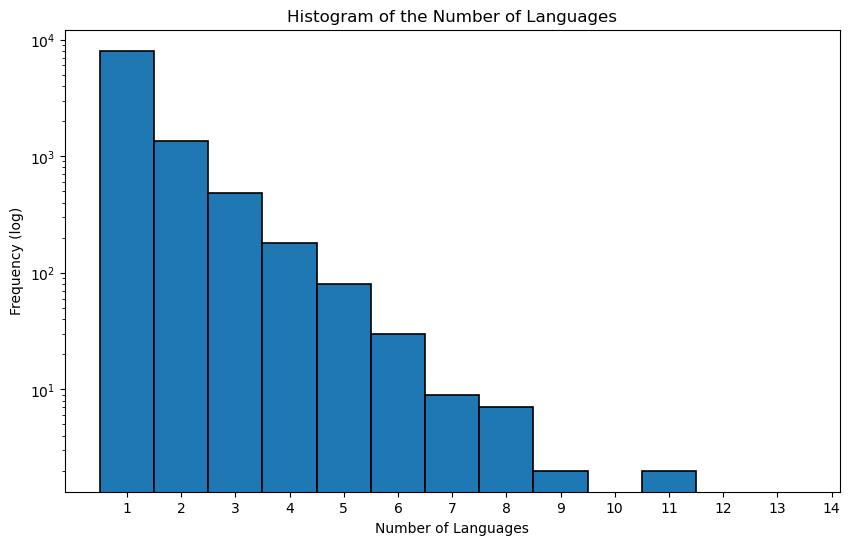

In [95]:
number_of_languages = movies_clean_languages.drop_duplicates(subset='Wiki_ID')['languages'].dropna().apply(lambda x: len(x))
# histogram of the number of genres
plt.figure(figsize=(10, 6))
plt.hist(number_of_languages,bins = np.arange(1, 15, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Languages')
plt.xticks(np.arange(1, 15, 1))
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Histogram of the Number of Languages')
plt.show()

In [96]:
# Calculate the number of languages for each movie
number_of_languages = movies_clean_languages.drop_duplicates(subset='Wiki_ID')['languages'].dropna().apply(lambda x: len(x))

# Create an interactive histogram
fig = go.Figure(data=[go.Histogram(
    x=number_of_languages,
    xbins=dict(start=0.5, end=14.5, size=1),  # Bin size and range
    marker=dict(line=dict(width=1.2, color='black')),  # Border line for each bin
    autobinx=False  # Disable automatic bin sizing
)])

# Update the layout
fig.update_layout(
    title='Histogram of the Number of Languages',
    xaxis=dict(
        title='Number of Languages',
        dtick=1  
    ),
    yaxis=dict(
        title='Frequency (log)',
        type='log' 
    ),
    bargap=0  
)

# Save the plot as an HTML file
#offline.plot(fig, filename='docs/plots/nb_languages.html', auto_open=False)

# Show the figure
fig.show()

# Network Analysis 
For coproduction 

I will be doing a network alowing us to visualize and analyse coproduction.

I start by creating a nice dataframe. To start I change all the countries in Imdb countries, using the CMU_to_IMDB mapping 

In [97]:
df = gross_language.copy()

country_mapping = pd.read_csv('dictionnaries/CMU_to_IMDB.csv')

country_mapping_dict = dict(zip(country_mapping['Country_mapped'], country_mapping['Country']))

# Function to map countries and raise an error for unmapped countries
def map_country(country):
    if country in country_mapping_dict:
        return country_mapping_dict[country]
    else:
        raise ValueError(f"Country '{country}' not found in mapping")

# Ensure every entry in 'countries' is a list, and apply the mapping
df['countries'] = df['countries'].apply(lambda x: [map_country(country) for country in x] if isinstance(x, list) else np.nan)

df.head()

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,genres,countries,Ratio_Female_to_Total,num_female,num_male,languages
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English]
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English]
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English]
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English]
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English]


I will now be adding the total gross for each film

In [98]:
def is_home_country(row):
    return row['country'] in row['countries']
# Sum up the gross for each movie in the `gross` dataframe
gross_sum = df.groupby('Wiki_ID')['gross'].sum().reset_index()
gross_sum.columns = ['Wiki_ID', 'total_gross']
# Merge this sum with the `movies` dataframe
df = df.merge(gross_sum, on='Wiki_ID', how='left')

df.dropna(subset=['countries'], inplace=True)

# Apply the is_home_country function to create the new column
df['is_home_country'] = df.apply(is_home_country, axis=1)

df.head()


,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,genres,countries,Ratio_Female_to_Total,num_female,num_male,languages,total_gross,is_home_country
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,True
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False


I will now create the network 

First we added a new feature to the graph, that contains the fraction of gross made in the production countries 

In [99]:
home_country_gross = df[df['is_home_country']].groupby('movie')['gross'].sum().reset_index()
home_country_gross.columns = ['movie', 'home_country_gross']

# Merge this data back with the original DataFrame
df = df.merge(home_country_gross, on='movie', how='left')

# Calculate the fraction of 'total_gross' made in home countries
df['home_country_fraction'] = df['home_country_gross'] / df['total_gross']

df.head(30)



,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,genres,countries,Ratio_Female_to_Total,num_female,num_male,languages,total_gross,is_home_country,home_country_gross,home_country_fraction
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,True,8709640.0,0.725997
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False,8709640.0,0.725997
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False,8709640.0,0.725997
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False,8709640.0,0.725997
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False,8709640.0,0.725997
5,tt0228333,975900,/m/03vyhn,Australia,ghosts of mars,160687.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False,8709640.0,0.725997
6,tt0228333,975900,/m/03vyhn,South Korea,ghosts of mars,33964.0,2001.0,"[Thriller, Adventure, Action, Science Fiction,...",[Domestic],0.352941,6.0,11.0,[English],11996794.0,False,8709640.0,0.725997
7,tt0097499,171005,/m/016ywb,Domestic,henry v,10161099.0,1989.0,"[Drama, History]",[United Kingdom],0.150000,3.0,17.0,[English],10161099.0,False,NaN,NaN
8,tt0058331,77856,/m/0kcn7,Domestic,mary poppins,102272727.0,1964.0,"[Drama, Comedy, Science Fiction, Family Film, ...",[Domestic],0.461538,6.0,7.0,[English],103078757.0,True,102272727.0,0.992180
9,tt0058331,77856,/m/0kcn7,Germany,mary poppins,271307.0,1964.0,"[Drama, Comedy, Science Fiction, Family Film, ...",[Domestic],0.461538,6.0,7.0,[English],103078757.0,False,102272727.0,0.992180


In [100]:
df.to_csv('network_df.csv', index=False)

here I create the coproduction network as follows : I will create an edge between all countries that did a coproduction the weight of the edge will be the sum of the gross revenue of the films corpoduced in the countries 

In [101]:
df_coprod = df[df['is_home_country']].copy()
df_coprod = df_coprod[df_coprod['countries'].apply(lambda x: len(x) > 1)]
df_coprod = df_coprod[['movie', 'countries','total_gross']]
df_coprod = df_coprod.drop_duplicates(subset='movie')

df_coprod.head()

,movie,countries,total_gross
25,rudo y cursi,"[Mexico, Domestic]",11169232.0
51,closing the ring,"[Domestic, Canada, United Kingdom]",1438942.0
64,hermanas,"[Spain, Argentina, Brazil]",179121.0
114,becoming jane,"[Ireland, United Kingdom]",37064067.0
148,heidi fleiss: hollywood madam,"[Domestic, Canada, United Kingdom, Germany]",34402.0


In [102]:
from itertools import combinations
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Iterate over each row in the DataFrame
for index, row in df_coprod.iterrows():
    # Get all combinations of two countries for each movie
    for pair in combinations(row['countries'], 2):
        # Check if the edge already exists
        if G.has_edge(pair[0], pair[1]):
            # Update the weight (total_gross) by adding the new value
            G[pair[0]][pair[1]]['weight'] += row['total_gross']
        else:
            # Add a new edge with the total_gross as the initial weight
            G.add_edge(pair[0], pair[1], weight=row['total_gross'])

#print first 30 edges 
#print all nodes
list(G.nodes())


['Mexico',
 'Domestic',
 'Canada',
 'United Kingdom',
 'Spain',
 'Argentina',
 'Brazil',
 'Ireland',
 'Germany',
 'Hong Kong',
 'China',
 'France',
 'Italy',
 'Japan',
 'Australia',
 'New Zealand',
 'Switzerland',
 'India',
 'Poland',
 'Denmark',
 'Sweden',
 'Austria',
 'Hungary',
 'Chile',
 'South Korea',
 'South Africa',
 'Middle East',
 'Netherlands',
 'Norway',
 'Colombia',
 'Serbia and Montenegro',
 'Greece',
 'Slovakia',
 'Czech Republic',
 'Finland',
 'Jamaica',
 'Bolivia',
 'Romania',
 'Central America',
 'Morocco',
 'Israel',
 'Belgium',
 'Kenya',
 'Uruguay',
 'Palestine',
 'Kuwait',
 'United Arab Emirates',
 'Portugal',
 'Tunisia',
 'Peru',
 'Russia',
 'E/W Africa',
 'North Macedonia',
 'Yugoslavia',
 'Nigeria',
 'Singapore',
 'Malaysia',
 'Indonesia',
 'Malta',
 'Pakistan',
 'Panama',
 'Egypt',
 'Iceland',
 'Iraq',
 'S/E/W Africa',
 'Philippines',
 'Croatia',
 'Bosnia',
 'Russia/CIS',
 'Lebanon',
 'Mongolia',
 'Lithuania',
 'Puerto Rico',
 'Bangladesh',
 'Slovenia',
 'Venezu

Now we will create the map 

In [103]:
#we load the cooordinates for each country 
country_coords = pd.read_csv('dictionnaries/country_coordinates.csv')

# Create a dictionary of country coordinates
pos = dict(zip(country_coords['Country'], zip(country_coords['Longitude'],country_coords['Latitude'])))


Now we will try to make the graph interactive 

In [105]:
# Create a Plotly figure
fig = go.Figure()

# Compute node weights based on the sum of weights of edges connected to the node
node_weights = {node: 0 for node in G.nodes()}
for (u, v, data) in G.edges(data=True):
    weight = data['weight']
    node_weights[u] += weight
    node_weights[v] += weight

# Normalize the weights
max_weight = max(node_weights.values())
for node in node_weights:
    node_weights[node] = 15 * node_weights[node] / max_weight

visible_marker_size_factor = 15
invisible_marker_size = 15  # Minimum size to ensure visibility

for country in G.nodes():
    lon, lat = pos[country]
    if country in node_weights:
        node_weight = node_weights[country]
        revenue_in_millions = node_weight * max_weight / 15 / 1e6
        formatted_weight = "{:,.0f}M".format(revenue_in_millions)
        node_text = f"<b>{country}</b><br>Coproduced revenue : <b>${formatted_weight}</b>"

        
        # Ensure positive and non-zero weight for logarithmic scale
        adjusted_weight = max(node_weight, 1)
        visible_marker_size = np.log(adjusted_weight) * visible_marker_size_factor

        # Add visible marker
        fig.add_trace(go.Scattergeo(
            lon=[lon],
            lat=[lat],
            hoverinfo='text',
            text=node_text,
            mode='markers',
            marker=dict(size=visible_marker_size, color='red'),
        ))

        # Add invisible marker for improved hover interaction
        fig.add_trace(go.Scattergeo(
            lon=[lon],
            lat=[lat],
            hoverinfo='text',
            text=node_text,
            mode='markers',
            marker=dict(size=invisible_marker_size,color='red', opacity=0),  # Invisible but large enough for hovering
        ))

# Add edges
for (u, v, data) in G.edges(data=True):
    if u in pos and v in pos:
        start = pos[u]
        end = pos[v]
        weight = data['weight'] / max_weight * 15
        edge_text = f"Co-production between {u} and {v}, Revenue: {data['weight']:,.0f}"

        fig.add_trace(go.Scattergeo(
            lon=[start[0], end[0], None],  # None creates a segment (break) between edges
            lat=[start[1], end[1], None],
            mode='lines',
            line=dict(width=weight, color='blue'),
            hoverinfo='none',
            text=edge_text  # Text to display on hover
        ))

fig.update_layout(
    title='Interactive Map of Country Co-productions',
    showlegend=False,
    geo=dict(
        projection_type='natural earth',
        showland=True,
        landcolor='lightgreen',
        countrycolor='gray',
    )
)

fig.show()

# Export to HTML
# html_file_path = 'docs/plots/country_co-productions.html'
# fig.write_html(html_file_path)



## GENRE ANALYSIS

I will now be doing an analysis of which combination of genre country works the best 

To do that I will compute for each contry,genre couple a number which is a factor representing the ratio of average exported gross of this combination / average exported gross of the country 

This number represents how much more this genre exports compared to average in a given country

I want to create a dataframe with one column for each (country,genre) that has at least a certain number of films in the column there will be the average exported gross for a film of the country, the average exported gross for films of the given genre, the number of films that have some exported gross for the country and the number of films for the country and genre

In [106]:
df_country_genre = df.copy()

# Explode the genres column so each genre has its own row
df_country_genre = df_country_genre.explode('genres')

# Group by country and genre to calculate average exported gross and count
avg_gross_genre_country = df_country_genre.groupby(['country', 'genres']).agg(
    avg_exported_gross_genre=('gross', 'mean'),
    film_count_genre=('tconst', 'count')
).reset_index()

# Group by country to calculate average exported gross
avg_gross_country = df_country_genre.groupby('country').agg(
    avg_exported_gross_country=('gross', 'mean'),
    film_count_country=('tconst', 'count')
).reset_index()

# Merge the two DataFrames
merged_df = pd.merge(avg_gross_genre_country, avg_gross_country, on='country')

# Calculate the factor
merged_df['genre_country_factor'] = merged_df['avg_exported_gross_genre'] / merged_df['avg_exported_gross_country']

# Filter rows based on a minimum number of films (replace 'min_films' with your threshold)
min_films = 50  # Example threshold
filtered_df = merged_df[merged_df['film_count_genre'] >= min_films]

# Selecting relevant columns
final_df = filtered_df[['country', 'genres', 'avg_exported_gross_genre', 'avg_exported_gross_country', 'film_count_genre', 'film_count_country', 'genre_country_factor']]

# Display the DataFrame
final_df.sort_values(by='genre_country_factor',ascending=False).head(30)


,country,genres,avg_exported_gross_genre,avg_exported_gross_country,film_count_genre,film_count_country,genre_country_factor
231,Chile,Family Film,1.209402e+06,5.211344e+05,208,4453,2.320710
1426,Slovakia,Family Film,3.021802e+05,1.330124e+05,132,2775,2.271819
1772,Venezuela,Family Film,2.322260e+06,1.033647e+06,173,3621,2.246666
6,Argentina,Family Film,2.210666e+06,9.870704e+05,222,5313,2.239623
1233,Poland,Family Film,2.439753e+06,1.115491e+06,196,4334,2.187157
338,Czech Republic,Family Film,7.427228e+05,3.412333e+05,194,4647,2.176584
1199,Peru,Family Film,1.037798e+06,4.811570e+05,181,3986,2.156881
957,Mexico,Family Film,7.197726e+06,3.343327e+06,277,6973,2.152864
1250,Portugal,Family Film,1.167662e+06,5.428290e+05,197,5708,2.151068
542,France,Family Film,1.115876e+07,5.206450e+06,292,8194,2.143256


# Creation of new genres 

I will now be analysing Genres and I will try to see if we can simplify the genres for better and clearer analysis 

In [107]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# First, keep only columns we need and drop duplicates
genres_df = df[['Wiki_ID', 'genres']].drop_duplicates(subset='Wiki_ID')

# Ensure that each entry in 'genres' is a list
genres_df['genres'] = genres_df['genres'].apply(lambda x: x if isinstance(x, list) else [])

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# One-hot encode the genres
one_hot_genres = pd.DataFrame(mlb.fit_transform(genres_df['genres']),
                              columns=mlb.classes_,
                              index=genres_df.index)

# Drop the original 'genres' column
genres_df = genres_df.drop('genres', axis=1)

# Join the one-hot encoded genres with the 'Wiki_ID'
genres_df = genres_df.join(one_hot_genres)

genres_df.head()


,Wiki_ID,Action,Adventure,Comedy,Crime,Documentary,Drama,Family Film,History,Horror,Indie,Musical,Mystery,Romance Film,Science Fiction,Teen,Thriller,World cinema
0,975900,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
7,171005,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
8,77856,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0
17,21926710,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
18,156558,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [108]:
import pandas as pd
from collections import defaultdict

# Assuming your DataFrame is named genres_df and the genre columns start from the second column
genre_columns = genres_df.columns[1:]  # Adjust this if your DataFrame structure is different

# Identify key genres
key_genres = [genre for genre in genre_columns if len(genre.split()) == 1]  # Example criterion: genres with only one word

# Create a dictionary to store genres with key genres as a substring
key_genre_dict = defaultdict(list)

# Iterate over each genre and check if any key genre is a substring
for genre in genre_columns:
    for key_genre in key_genres:
        if key_genre.lower() in genre.lower():  # Case insensitive check
            key_genre_dict[key_genre].append(genre)

# Filter out key genres that have only one (or none) associated genres
key_genre_dict = {key_genre: genres for key_genre, genres in key_genre_dict.items() if len(genres) > 1}

# Convert it to a standard dictionary for easier reading
key_genre_dict = dict(key_genre_dict)

# # Print the dictionary
for key_genre, genres in key_genre_dict.items():
    print(f"Key Genre: {key_genre}, Related Genres: {genres}")


I will now remove pairs with the following keys as they are not appropriate : Cult,Travel,Film

I will merge the values of the Music key_genre in those of the Musical key_genre 

In [109]:
# Remove the specified key genres
keys_to_remove = ['Cult', 'Travel', 'Film']
for key in keys_to_remove:
    key_genre_dict.pop(key, None)  # Use pop with None to avoid KeyError if the key doesn't exist

# Merge 'Music' into 'Musical'
if 'Music' in key_genre_dict and 'Musical' in key_genre_dict:
    # Extend the list of genres for 'Musical' with those from 'Music'
    key_genre_dict['Musical'].extend(key_genre_dict['Music'])

    # Remove duplicates if any
    key_genre_dict['Musical'] = list(set(key_genre_dict['Musical']))

    # Remove the 'Music' key
    key_genre_dict.pop('Music', None)

# # Print the updated dictionary
for key_genre, genres in key_genre_dict.items():
    print(f"Key Genre: {key_genre}, Related Genres: {genres}")

I will now create a new dataframe with a new one hot encoding where if there is a one in any of the values a one is put in the key_genre and all columns that are in one of the values but not in any key genre are removed 

In [110]:
# Step 1: Update key genre columns
for key_genre, genres in key_genre_dict.items():
    # For each film, if there is a 1 in one of its associated genres, set the key genre to 1
    genres_df[key_genre] = genres_df[genres].max(axis=1)

# Step 2: Create a list of all columns to remove
# These are genres that are values in the dictionary but not keys
genres_to_remove = set(sum(key_genre_dict.values(), [])) - set(key_genre_dict.keys())

# Step 3: Remove these columns from the DataFrame
man_genres_df = genres_df.drop(columns=genres_to_remove, errors='ignore')

man_genres_df.head()

,Wiki_ID,Action,Adventure,Comedy,Crime,Documentary,Drama,Family Film,History,Horror,Indie,Musical,Mystery,Romance Film,Science Fiction,Teen,Thriller,World cinema
0,975900,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
7,171005,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
8,77856,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0
17,21926710,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
18,156558,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


Lets analyse genres to see which ones we can take out 

In [111]:

genre_frequencies = man_genres_df.drop('Wiki_ID', axis=1).sum()
# Define a threshold for low frequency

frequency_threshold = 50

# Filter out genres below the threshold
low_frequency_genres = genre_frequencies[genre_frequencies < frequency_threshold]

# Convert the Series to a DataFrame for better readability
low_freq_df = low_frequency_genres.to_frame('Frequency')

# Reset the index to make the genres a column
low_freq_df.reset_index(inplace=True)
low_freq_df.rename(columns={'index': 'Genre'}, inplace=True)


In [112]:
# Remove columns for low frequency genres
genres_to_remove = low_freq_df['Genre']
reduced_genres_df = man_genres_df.drop(columns=genres_to_remove, errors='ignore')
reduced_genres_df.head()

,Wiki_ID,Action,Adventure,Comedy,Crime,Documentary,Drama,Family Film,History,Horror,Indie,Musical,Mystery,Romance Film,Science Fiction,Teen,Thriller,World cinema
0,975900,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
7,171005,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
8,77856,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0
17,21926710,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
18,156558,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [113]:
def compute_conditional_prob_matrix(df, exclude_column=None):
    """
    Compute a conditional probability matrix for genres in a film DataFrame.

    :param df: Pandas DataFrame with one-hot encoded genres.
    :param exclude_column: Column to exclude from the calculation (e.g., an ID column).
    :return: DataFrame representing the conditional probability matrix.
    """
    # If there's a column to exclude (like 'Wiki_ID'), drop it
    if exclude_column:
        df = df.drop(exclude_column, axis=1)

    # Initialize an empty DataFrame for conditional probabilities
    cond_prob_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

    # Calculate conditional probabilities
    for genre_a in df.columns:
        for genre_b in df.columns:
            if genre_a != genre_b:
                total_genre_a = df[genre_a].sum()
                co_occurrence = (df[genre_a] & df[genre_b]).sum()
                cond_prob_matrix.at[genre_a, genre_b] = co_occurrence / total_genre_a if total_genre_a else 0

    return cond_prob_matrix

In [114]:
# Assuming genres_df is your DataFrame with one-hot encoded genres
genres = reduced_genres_df.columns.drop('Wiki_ID')

# Initialize a DataFrame to store conditional probabilities
cond_probs = compute_conditional_prob_matrix(reduced_genres_df, exclude_column='Wiki_ID')

# Threshold for high conditional probability
threshold = 0.85

# Iterate through the conditional probabilities DataFrame
for genre_a in cond_probs.index:
    for genre_b in cond_probs.columns:
        # Check if the conditional probability exceeds the threshold
        if cond_probs.at[genre_a, genre_b] > threshold:
            print(f"{genre_a} -> {genre_b}: {cond_probs.at[genre_a, genre_b]:.2f}")


In [115]:
# Threshold for conditional probability
threshold = 0.85

# Create a dictionary for merge mapping
merge_map = {}

# Identify the genres to be merged
for genre_a in cond_probs.index:
    # Find the genre with the highest conditional probability conditioned on genre_a
    highest_prob = cond_probs.loc[genre_a].max()
    if highest_prob > threshold:
        genre_b = cond_probs.loc[genre_a].idxmax()
        merge_map[genre_a] = genre_b

# Update the DataFrame
for genre_to_merge, target_genre in merge_map.items():
    # For each movie, if it's classified under genre_to_merge, also classify it under target_genre
    reduced_genres_df[target_genre] = reduced_genres_df[target_genre] | reduced_genres_df[genre_to_merge]

# Optional: Remove merged genre columns
reduced_genres_df = reduced_genres_df.drop(columns=list(merge_map.keys()))

print("Merging completed. Updated DataFrame:")
print(reduced_genres_df)

Merging completed. Updated DataFrame:
        Wiki_ID  Action  Adventure  Comedy  Crime  Documentary  Drama  \
0        975900       1          1       0      0            0      0   
7        171005       0          0       0      0            0      1   
8         77856       0          0       1      0            0      1   
17     21926710       0          0       1      0            0      0   
18       156558       0          0       0      1            0      1   
...         ...     ...        ...     ...    ...          ...    ...   
89511   1673588       0          0       1      0            0      1   
89512   7761830       0          1       1      0            0      0   
89513   1918494       0          0       1      0            0      1   
89518    664006       0          0       0      1            0      1   
89519  34980460       0          0       0      0            1      1   

       Family Film  History  Horror  Indie  Musical  Mystery  Romance Film  \
0      

In [116]:
#for each genre we compute its occurnce in the dataset and we sort de genres 
genre_frequencies = reduced_genres_df.drop('Wiki_ID', axis=1).sum()
genre_frequencies.sort_values(ascending=False, inplace=True)
print(genre_frequencies)

Drama              6141
Comedy             4187
Romance Film       2711
Thriller           2645
Adventure          2171
Action             2062
Crime              1953
Indie              1937
World cinema       1472
Science Fiction    1336
Horror             1006
Family Film         958
Documentary         847
Musical             810
Mystery             786
History             607
Teen                435
dtype: int64


In [117]:
cond_prob_df = compute_conditional_prob_matrix(reduced_genres_df, exclude_column='Wiki_ID')

# Sort the genres by their frequency in descending order
sorted_genres = genre_frequencies.sort_values(ascending=False).index

# Iterate through each genre in the sorted order
for genre in sorted_genres:
    # Find the genre with the maximum conditional probability
    highest_prob_genre = cond_probs.loc[genre].idxmax()
    highest_prob_value = cond_probs.loc[genre, highest_prob_genre]

    # Print the genre, the genre with the highest conditional probability, and the probability value
    print(f"{genre} -> {highest_prob_genre} : {highest_prob_value:.2f}")


TypeError: reduction operation 'argmax' not allowed for this dtype

Let's map some obvious genres 

In [ ]:
map_genre = {
    'Animal Picture': 'Family Film',
    'War film': 'History',
    'Animation': 'Family Film',
    'Biography':'Documentary',
    'Cult': 'Indie',
    'Time travel': 'Science Fiction',
    'Doomsday film': 'Science Fiction',
    'Dance': 'Musical',
    'LGBT': 'Romance Film',
    'Erotica': 'Romance Film',
    'Supernatural': 'Horror',
    'Fantasy': 'Science Fiction',
    'Western': 'Adventure',
    'Chinese Movies': 'World cinema',
    'Japanese Movies': 'World cinema'
}

# Step 1: Update Values Based on Keys
for key_genre, value_genre in map_genre.items():
    # Check if both key_genre and value_genre exist in the DataFrame
    if key_genre in reduced_genres_df.columns and value_genre in reduced_genres_df.columns:
        # Update value_genre based on key_genre
        reduced_genres_df[value_genre] = reduced_genres_df[value_genre] | reduced_genres_df[key_genre]

# Step 2: Remove Key Genres
reduced_genres_df = reduced_genres_df.drop(columns=list(map_genre.keys()), errors='ignore')


In [ ]:
#for each genre we compute its occurnce in the dataset and we sort de genres 
genre_frequencies = reduced_genres_df.drop('Wiki_ID', axis=1).sum()
genre_frequencies.sort_values(ascending=False, inplace=True)
print(genre_frequencies)

Drama               6141
Comedy              4187
Romance Film        2711
Thriller            2645
Adventure           2171
Action              2062
Crime               1953
Indie               1937
World cinema        1472
Science Fiction     1336
Horror              1006
Family Film          958
Documentary          847
Musical              810
Mystery              786
History              607
Teen                 435
Sports               384
Ensemble Film        239
Black-and-white      204
Road movie           163
Political cinema     156
Spy                  116
Disaster              84
Detective             77
Remake                58
Chase Movie           56
dtype: int64


In [ ]:
# Step 1: Identify the top 15 genres
top_17_genres = genre_frequencies.sort_values(ascending=False).head(17).index

# Step 2: Calculate and print the percentage for each genre
for genre in reduced_genres_df.columns:
    if genre not in top_17_genres:
        # Count films that have this genre
        total_films_with_genre = reduced_genres_df[genre].sum()

        if total_films_with_genre > 0:
            # Count films that have this genre and at least one of the top 15 genres
            films_with_top_15 = reduced_genres_df[reduced_genres_df[genre] == 1][top_17_genres].sum(axis=1).gt(0).sum()

            # Calculate the percentage
            percentage = (films_with_top_15 / total_films_with_genre) * 100

            # Print the result
            print(f"{genre}: {percentage:.2f}% of films also have a top 15 genre")

Wiki_ID: 0.00% of films also have a top 15 genre
Black-and-white: 98.53% of films also have a top 15 genre
Chase Movie: 100.00% of films also have a top 15 genre
Detective: 100.00% of films also have a top 15 genre
Disaster: 100.00% of films also have a top 15 genre
Ensemble Film: 100.00% of films also have a top 15 genre
Political cinema: 100.00% of films also have a top 15 genre
Remake: 100.00% of films also have a top 15 genre
Road movie: 100.00% of films also have a top 15 genre
Sports: 100.00% of films also have a top 15 genre
Spy: 100.00% of films also have a top 15 genre


In [ ]:
#we decide to only keep the top 17 genres 
top_17_genres = genre_frequencies.sort_values(ascending=False).head(17).index

# we modify the dataframe to only keep the top 17 genres
reduced_genres_df = reduced_genres_df[['Wiki_ID'] + list(top_17_genres)]
reduced_genres_df.columns

Index(['Wiki_ID', 'Drama', 'Comedy', 'Romance Film', 'Thriller', 'Adventure',
       'Action', 'Crime', 'Indie', 'World cinema', 'Science Fiction', 'Horror',
       'Family Film', 'Documentary', 'Musical', 'Mystery', 'History', 'Teen'],
      dtype='object')

We have our final dictionnary I now want to store it 

In [ ]:
# Step 1: Convert genre columns to lists
def genres_to_list(row, genre_columns):
    return [genre for genre in genre_columns if row[genre] == 1]

# List of genre columns (excluding Wiki_ID)
genre_columns = reduced_genres_df.columns.drop('Wiki_ID')

# Apply the function to each row
reduced_genres_df['genres'] = reduced_genres_df.apply(lambda row: genres_to_list(row, genre_columns), axis=1)

# Step 2: Create the new DataFrame with Wiki_ID and genres
genres = reduced_genres_df[['Wiki_ID', 'genres']]

# Display the new DataFrame
genres.head()

# We save the dataframe as a csv file
csv_file_path = 'dictionnaries/movies_genres.csv'

# Save the DataFrame to a CSV file
genres.to_csv(csv_file_path, index=False)

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,countries,Ratio_Female_to_Total,languages,genres
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
